In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

from copy import deepcopy

In [3]:
from sklearn import svm, preprocessing
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def get_labels(fname):
#     example fname: truck_30_pivothead_rzminus.mp4
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    identity = category+fnparts[1]
    trans = fnparts[3]
    return category, identity, trans

def get_categorylabel(fname):
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    return category

def get_identitylabel(fname):
    fnparts = fname.split('.')[0].split('_')
    category = fnparts[0]
    identity = category+fnparts[1]
    return identity

def get_translabel(fname):
    fnparts = fname.split('.')[0].split('_')
    translabel = fnparts[3]
    return translabel

def add_labels_to_df(df, labels):
    if 'category' in labels:
        df['category'] = df['fnames'].apply(lambda fname: get_categorylabel(fname))
    if 'identity' in labels:
        df['identity'] = df['fnames'].apply(lambda fname: get_identitylabel(fname))
    if 'transformation' in labels:
        df['transformation'] = df['fnames'].apply(lambda fname: get_translabel(fname))
    return df

In [6]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may15/s3/'
# emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/'
# emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may10/'
fpathlist = []
for fname in os.listdir(emb_root):
    fpath = emb_root+fname 
    if Path(fpath).suffix=='.csv':
        fpathlist.append(fpath)
        print(fpath)

/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may15/s3/embeddings_g2_seed_721_adamw_pre.g0g1.csv
/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may15/s3/embeddings_g0_seed_721_adamw_pre.g0g0.csv


In [25]:
fp = fpathlist[0]
xdf0 = pd.read_csv(fp)
xdf0

,fnames,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,...,dim758,dim759,dim760,dim761,dim762,dim763,dim764,dim765,dim766,dim767
0,airplane_01_pivothead_absent.mp4,-0.001225,-0.004773,0.003310,-0.004939,-0.027015,-0.006269,-0.015138,0.053008,0.011834,...,-0.010510,0.008616,-0.002383,0.025282,-0.008555,0.007403,-0.021653,0.099717,-0.011814,0.018120
1,airplane_01_pivothead_hodgepodge.mp4,-0.001325,-0.001331,0.000013,0.000276,-0.021662,-0.008958,-0.015678,0.046692,0.015180,...,-0.007505,0.008939,-0.000695,0.021631,-0.006190,0.006471,-0.016339,0.125433,-0.010858,0.015624
2,airplane_01_pivothead_present.mp4,-0.001567,-0.000682,0.002166,-0.001526,-0.024319,-0.006696,-0.017441,0.050906,0.012419,...,-0.009729,0.006321,-0.001212,0.020738,-0.007581,0.005163,-0.018740,0.091395,-0.008619,0.015306
3,airplane_01_pivothead_rxminus.mp4,-0.003966,-0.002408,-0.000738,-0.001686,-0.022299,-0.010283,-0.017541,0.050472,0.013339,...,-0.010030,0.009315,-0.001933,0.020985,-0.007183,0.006665,-0.012820,0.097304,-0.010625,0.016475
4,airplane_01_pivothead_rxplus.mp4,-0.005656,-0.002169,-0.000829,-0.002909,-0.022165,-0.008700,-0.019896,0.049869,0.011368,...,-0.010838,0.010871,-0.003595,0.024373,-0.006847,0.008402,-0.014246,0.101600,-0.010518,0.017295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,truck_30_pivothead_rzminus.mp4,0.003278,-0.000683,0.004002,0.002076,-0.025679,-0.005245,-0.012941,0.047079,0.015706,...,-0.004878,0.001294,0.001976,0.012951,-0.006365,0.000073,-0.022260,0.091820,-0.009088,0.010736
4304,truck_30_pivothead_rzplus.mp4,0.000562,-0.002129,0.005471,-0.000973,-0.025996,-0.003847,-0.011277,0.048111,0.013171,...,-0.006224,0.003520,-0.000156,0.017527,-0.006815,0.002191,-0.021960,0.091692,-0.009750,0.012910
4305,truck_30_pivothead_tx.mp4,0.002163,-0.000892,0.003076,0.001924,-0.026473,-0.005666,-0.012193,0.049883,0.015470,...,-0.005880,0.002597,0.001655,0.014557,-0.007050,0.000822,-0.019047,0.091762,-0.009455,0.011061
4306,truck_30_pivothead_ty.mp4,-0.002097,-0.003153,0.003372,-0.000164,-0.025096,-0.005626,-0.016013,0.051062,0.015029,...,-0.006549,0.005637,-0.000927,0.019483,-0.007786,0.004476,-0.021687,0.082646,-0.010759,0.013601


In [10]:
for item in xdf0['fnames'].iloc[:10]:
    print(get_labels(item))

('airplane', 'airplane01', 'absent')
('airplane', 'airplane01', 'hodgepodge')
('airplane', 'airplane01', 'present')
('airplane', 'airplane01', 'rxminus')
('airplane', 'airplane01', 'rxplus')
('airplane', 'airplane01', 'ryminus')
('airplane', 'airplane01', 'ryplus')
('airplane', 'airplane01', 'rzminus')
('airplane', 'airplane01', 'rzplus')
('airplane', 'airplane01', 'tx')


In [27]:
xdf0 = add_labels_to_df(xdf0, ['category', 'identity','transformation'])

In [20]:
print(xdf0['category'].unique())
print(xdf0['identity'].unique())
print(xdf0['transformation'].unique())

['airplane' 'ball' 'car' 'cat' 'cup' 'duck' 'giraffe' 'helicopter' 'horse'
 'mug' 'spoon' 'truck']
['airplane01' 'airplane02' 'airplane03' 'airplane04' 'airplane05'
 'airplane06' 'airplane07' 'airplane08' 'airplane09' 'airplane10'
 'airplane11' 'airplane12' 'airplane13' 'airplane14' 'airplane15'
 'airplane16' 'airplane17' 'airplane18' 'airplane19' 'airplane20'
 'airplane21' 'airplane22' 'airplane23' 'airplane24' 'airplane25'
 'airplane26' 'airplane27' 'airplane28' 'airplane29' 'airplane30' 'ball01'
 'ball02' 'ball03' 'ball04' 'ball05' 'ball06' 'ball07' 'ball08' 'ball09'
 'ball10' 'ball11' 'ball12' 'ball13' 'ball14' 'ball15' 'ball16' 'ball17'
 'ball18' 'ball19' 'ball20' 'ball21' 'ball22' 'ball23' 'ball24' 'ball25'
 'ball26' 'ball27' 'ball28' 'ball29' 'ball30' 'car01' 'car02' 'car03'
 'car04' 'car05' 'car06' 'car07' 'car08' 'car09' 'car10' 'car11' 'car12'
 'car13' 'car14' 'car15' 'car16' 'car17' 'car18' 'car19' 'car20' 'car21'
 'car22' 'car23' 'car24' 'car25' 'car26' 'car27' 'car28' 'car

In [28]:
le_cat = preprocessing.LabelEncoder()
xdf0['category_int']=le_cat.fit_transform(xdf0['category'])

In [29]:
le_id = preprocessing.LabelEncoder()
xdf0['identity_int']=le_id.fit_transform(xdf0['identity'])

In [30]:
le_tr = preprocessing.LabelEncoder()
xdf0['transformation_int']=le_tr.fit_transform(xdf0['transformation'])

In [31]:
xdf0['transformation_int']

0        0
1        1
2        2
3        5
4        6
        ..
4303     9
4304    11
4305    12
4306    13
4307    14
Name: transformation_int, Length: 4308, dtype: int64

In [33]:
xdf0.columns

Index(['fnames', 'dim0', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6',
       'dim7', 'dim8',
       ...
       'dim764', 'dim765', 'dim766', 'dim767', 'category', 'identity',
       'transformation', 'category_int', 'identity_int', 'transformation_int'],
      dtype='object', length=775)

In [34]:
select_cols = ['dim'+str(i)
              for i in range(768)]
X = xdf0[select_cols]
y = xdf0['transformation_int']
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(X, y)

/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [72]:
def get_separability_score(df, label, method='sgd', ret_preds=False):
    # method: sgd or svm
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(df[label])
    
    X_cols = ['dim'+str(i)
              for i in range(768)]
    X = df[X_cols]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    if method=='svm':
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(random_state=0, tol=1e-4))
    elif method=='sgd':
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-4, n_jobs=30))#, loss='log_loss'))
    else:
        raise ValueError()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    if ret_preds:
        preds = clf.predict(X_test)
        return train_score, test_score, preds, y_test
    return train_score, test_score

In [8]:
def fix_fnames(df):
    df.iloc[2163,0] = 'giraffe_02_pivothead_rzplus.mp4'
    df.iloc[1851,0]='duck_06_pivothead_rxminus.mp4'
    df.iloc[751,0] = 'car_03_pivothead_rzminus.mp4'
    return df

In [9]:
def eval_embs(fp, method='sgd', ret_preds=False):
    scores = {}
    
    df = pd.read_csv(fp)

#     fix 3 filenames. for older files
    df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    
#     if ret_preds
    scores['category'] = get_separability_score(df, 'category', method=method)
#     scores['identity'] = get_separability_score(df, 'identity', method=method)
    scores['transformation'] = get_separability_score(df, 'transformation', method=method)
    return scores

In [10]:
from time import time

In [11]:
fpathlist

['/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_211_sgd_pre.g0g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_212_sgd_pre.g0g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_213_sgd_pre.g0g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_212_sgd_pre.g3g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_gr_seed_211_sgd_pre.grgr.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g0_seed_213_sgd_pre.g2g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_213_sgd_pre.g2g2.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/

In [14]:
fp = fpathlist[3] #g2: 4 g0:3. categ: -2
print(Path(fp).stem)
df = pd.read_csv(fp)
df = fix_fnames(df)
df = add_labels_to_df(df, ['category', 'identity','transformation'])
method='sgd'
train_score, test_score, preds, targets = get_separability_score(df, 'transformation', method=method, ret_preds=True)
print('train_score, test_score:',train_score, test_score)

embeddings_g2_seed_201_10ep_10fps_base_tb5fps
train_score, test_score: 0.7893277893277894 0.6954992967651196


In [12]:
idx_list = [4,12]
for idx in idx_list: #g2: 4 g0:3. categ: -2
    fp = fpathlist[idx]
    print(Path(fp).stem)
    df = pd.read_csv(fp)
    df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    method='sgd'
    train_score, test_score, preds, targets = get_separability_score(df, 'transformation', method=method, ret_preds=True)
    print('train_score, test_score:',train_score, test_score)

embeddings_g2_seed_211_10ep_30fps_base_sgd
train_score, test_score: 0.5571725571725572 0.4451476793248945
embeddings_g0_seed_211_10ep_30fps_base_sgd
train_score, test_score: 0.6860706860706861 0.5639943741209564


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
def plot_confusionmatrix(targets, preds, labels, ax=None):
    cmlabels = list(labels.keys())
    plotlabels = list(labels.values())
    cm = confusion_matrix(targets, preds, normalize='true', labels=cmlabels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=plotlabels)
    if ax is None:
        fig,ax = plt.subplots(1,1, figsize=(10,10))
    disp.plot(ax=ax, im_kw={'vmax':0.7, 'cmap':'hot'})

Text(0.5, 1.0, 'embeddings_g2_seed_101_10ep 0.73 0.62')

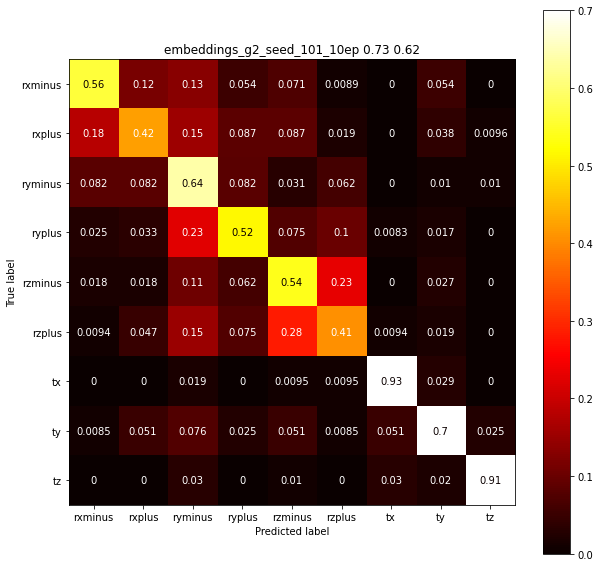

In [141]:
# labels = pd.unique(df['transformation'])
labels = {3:'rxminus', 4:'rxplus', 5:'ryminus',
       6:'ryplus', 7:'rzminus', 8:'rzplus', 9:'tx', 10:'ty', 11:'tz'}
# labels = pd.unique(df['category'])
fig,ax = plt.subplots(1,1, figsize=(10,10))
plot_confusionmatrix(targets, preds, labels, ax=ax)
ax.set_title(Path(fp).stem+' %.2f %.2f'%(train_score, test_score))

In [122]:
fp ='/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may10/embeddings_untrained_seed_402_fr3.csv'
print(Path(fp).stem)
df = pd.read_csv(fp)
df = fix_fnames(df)
df = add_labels_to_df(df, ['category', 'identity','transformation'])
method='sgd'
train_score, test_score, preds, targets = get_separability_score(df, 'transformation', method=method, ret_preds=True)
print('train_score, test_score:',train_score, test_score)

embeddings_untrained_seed_402_fr3
train_score, test_score: 0.5384615384615384 0.44655414908579466


Text(0.5, 1.0, 'embeddings_untrained_seed_402_fr3 0.54 0.45')

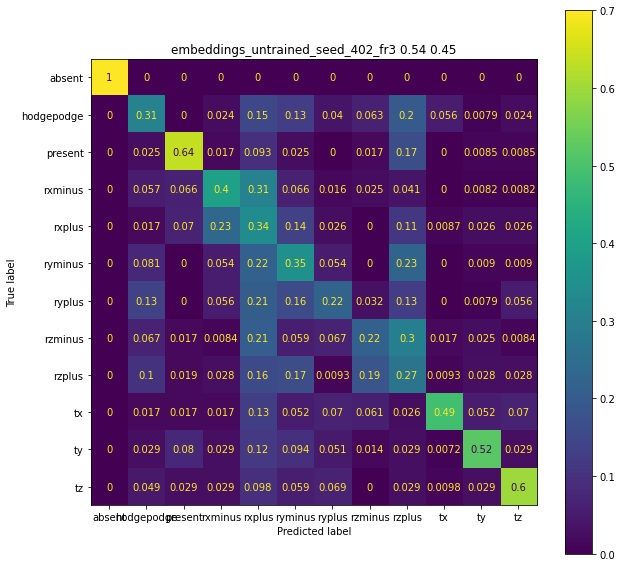

In [123]:
labels = pd.unique(df['transformation'])
# labels = pd.unique(df['category'])
fig,ax = plt.subplots(1,1, figsize=(10,10))
plot_confusionmatrix(targets, preds, labels, ax=ax)
ax.set_title(Path(fp).stem+' %.2f %.2f'%(train_score, test_score))

In [15]:
# del fpathlist[2]
for fp in fpathlist:
    print('--------------------')
    print(Path(fp).stem)
#     t0 = time()
    print(eval_embs(fp, method='sgd'))
#     print(time()-t0)

--------------------
embeddings_g2_seed_211_sgd_pre.g0g1
{'category': (0.6247401247401247, 0.40717299578059074), 'transformation': (0.72002772002772, 0.6286919831223629)}
--------------------
embeddings_g2_seed_212_sgd_pre.g0g1
{'category': (0.6275121275121275, 0.3931082981715893), 'transformation': (0.7300762300762301, 0.6265822784810127)}
--------------------
embeddings_gr_seed_211_sgd_pre.grgr
{'category': (0.5727650727650727, 0.40014064697609003), 'transformation': (0.665973665973666, 0.5077355836849508)}
--------------------
embeddings_g2_seed_211_sgd_pre.g2g2
{'category': (0.4074844074844075, 0.27637130801687765), 'transformation': (0.5232155232155232, 0.4247538677918425)}
--------------------
embeddings_g0_seed_211_sgd_pre.g2g1
{'category': (0.20893970893970895, 0.170182841068917), 'transformation': (0.4171864171864172, 0.38255977496483823)}
--------------------
embeddings_gr_seed_212_sgd_pre.grgr
{'category': (0.6337491337491338, 0.3959212376933896), 'transformation': (0.734234

In [20]:
fp ='/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may10/embeddings_untrained_seed_402_fr3.csv'
print(Path(fp).stem)
t0 = time()
print(eval_embs(fp, method='sgd'))
print(time()-t0)

embeddings_untrained_seed_402_fr3
{'category': 0.22925457102672292, 'identity': 0.1350210970464135, 'transformation': 0.4620253164556962}
2.908228635787964


In [22]:
fp = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may10/embeddings_g0_seed_401_10fps.3ep.csv'
print(Path(fp).stem)
t0 = time()
print(eval_embs(fp, method='sgd'))
print(time()-t0)

embeddings_g0_seed_401_10fps.3ep
{'category': 0.15260196905766527, 'identity': 0.14275668073136427, 'transformation': 0.409985935302391}
2.928339719772339


## Summary of observations from May10

LinearSVC is slower than SGD, but gives a higher score in general.

curriculum is still better than anti-curriculum. but they're both worse than the untrained model, given the models we have.

Update on May 14:
All models do better than the untrained. Curriculum effect is there both in terms of convergence rate and downstream performance.

## Make plots

In [18]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/'

In [19]:
def get_seed(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
    return parts[3]

def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[1]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
    return full_tag

In [20]:
def proc_fp(fp, score_type):
    df = pd.read_csv(fp)
    df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    method='sgd'
    train_score, test_score, preds, targets = get_separability_score(df, score_type, method=method, ret_preds=True)
    return test_score

In [40]:
tagname_dict = {
    'g0':'Dev.', 
    'g0g1': 'Dev.', 
    'g0g1g2': 'Dev.',
    'g2':'Anti-Dev.', 
    'g2g1': 'Anti-Dev.', 
    'g2g1g0': 'Anti-Dev.',
    'gr': 'Random',
    'grgr': 'Random',
    'grgrgr': 'Random',
    'g2g2': 'Oldest Only',
    'g2g2g2': 'Oldest Only',
    'g3': 'Adult',
    'g3g1': 'Adult',
    'g3g1g2': 'Adult',
#     'g0': 'Youngest Only',
    'g0g0': 'Youngest Only',
    'g0g0g0': 'Youngest Only'}

In [24]:
emb_dir

'/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/'

In [25]:
for fname in os.listdir(emb_dir):
    print(fname)

embeddings_g2_seed_563_sgd_pre.g2g2.csv
embeddings_g2_seed_562_sgd_pre.g2g2.csv
embeddings_g0_seed_661_sgd_pre.g0g0.csv
embeddings_g2_seed_211_sgd_pre.g0g1.csv
embeddings_g2_seed_212_sgd_pre.g0g1.csv
embeddings_g2_seed_213_sgd_pre.g0g1.csv
tmp
embeddings_g2_seed_212_sgd_pre.g3g1.csv
embeddings_gr_seed_211_sgd_pre.grgr.csv
embeddings_g0_seed_213_sgd_pre.g2g1.csv
embeddings_g2_seed_213_sgd_pre.g2g2.csv
.ipynb_checkpoints
embeddings_g0_seed_662_sgd_pre.g0g0.csv
embeddings_g2_seed_211_sgd_pre.g2g2.csv
embeddings_g0_seed_211_sgd_pre.g2g1.csv
embeddings_g2_seed_212_sgd_pre.g2g2.csv
embeddings_gr_seed_212_sgd_pre.grgr.csv
embeddings_g2_seed_211_sgd_pre.g3g1.csv
embeddings_g2_seed_213_sgd_pre.g3g1.csv
embeddings_g0_seed_212_sgd_pre.g2g1.csv
embeddings_g0_seed_663_sgd_pre.g0g0.csv
embeddings_g2_seed_561_sgd_pre.g2g2.csv
embeddings_gr_seed_213_sgd_pre.grgr.csv


In [41]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(Path(fp).stem)
        tag = get_tag(fp)
#         print(tag)
        curr = tagname_dict[tag]
        tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

100%|███████████████████████████████████████████| 21/21 [00:34<00:00,  1.66s/it]


In [42]:
df_all = pd.DataFrame.from_records(record_list)

In [43]:
hue_order = ['Dev.',
            'Anti-Dev.',
            'Random',
            'Adult']

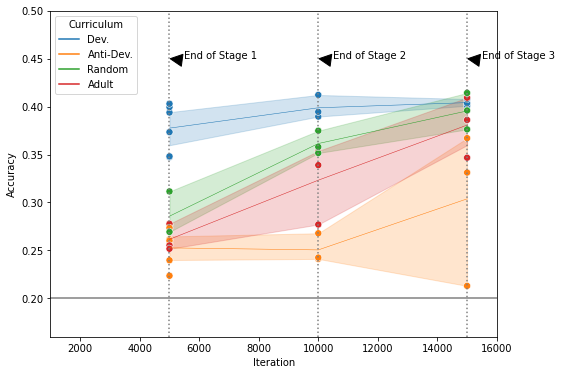

In [45]:
cdata = df_all[(df_all['Curriculum']!='Youngest Only') &
              (df_all['Curriculum']!='Oldest Only')]

fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5,
            hue_order=hue_order)
sns.scatterplot(data=cdata, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50,
            hue_order=hue_order)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


plt.savefig('fig_toybox_categorization.pdf', dpi=300)

In [70]:
df_all = pd.DataFrame.from_records(record_list)
# df_all.to_csv('data_toybox_categorization.csv', index=False)

In [46]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        tag = get_tag(fp)
        curr = tagname_dict[tag]
        tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

100%|███████████████████████████████████████████| 21/21 [00:37<00:00,  1.78s/it]


In [47]:
df_all = pd.DataFrame.from_records(record_list)

In [48]:
# df_all.to_csv('data_toybox_trasnformation.csv', index=False)

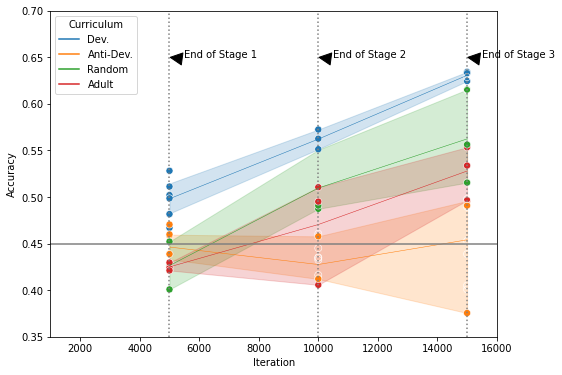

In [50]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5,
            hue_order=hue_order)
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50,
               hue_order=hue_order)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.35,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


plt.savefig('fig_toybox_transformation.pdf', dpi=300)

### Temp: youngest only and oldest only

In [11]:
def get_seed(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
    return parts[3]

def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[1]
    
    seed = get_seed(fp)
    try:
        seed = int(seed)
    except:
        warnings.warn('seed cannot be converted to int for'+stem)
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        # stage 1 results
        if seed>500: ##### buggy assumption. relies on the seed for distinguishing between g0 of g0g0g0 and g0 of g0g1g2
            glast = glast+'o'
        full_tag = glast
    return full_tag

tagname_dict = {
    'g0':'Dev.', 
    'g0g1': 'Dev.', 
    'g0g1g2': 'Dev.',
    'g2':'Anti-Dev.', 
    'g2g1': 'Anti-Dev.', 
    'g2g1g0': 'Anti-Dev.',
    'gr': 'Random',
    'grgr': 'Random',
    'grgrgr': 'Random',
    'g2o': 'Oldest Only',
    'g2g2': 'Oldest Only',
    'g2g2g2': 'Oldest Only',
    'g3': 'Adult',
    'g3g1': 'Adult',
    'g3g1g2': 'Adult',
    'g0o':'Youngest Only',
    'g0g0':'Youngest Only',
    'g0g0g0':'Youngest Only'}

In [14]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/'

In [12]:
def proc_fp(fp, score_type):
    df = pd.read_csv(fp)
#     df = fix_fnames(df)
    df = add_labels_to_df(df, ['category', 'identity','transformation'])
    method='sgd'
    train_score, test_score, preds, targets = get_separability_score(df, score_type, method=method, ret_preds=True)
    return test_score

In [19]:
fpathlist

['/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_563_sgd_pre.g2g2.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_562_sgd_pre.g2g2.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g0_seed_661_sgd_pre.g0g0.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_211_sgd_pre.g0g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_212_sgd_pre.g0g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_213_sgd_pre.g0g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may14/s3/embeddings_g2_seed_212_sgd_pre.g3g1.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/

In [16]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    print('---------------stage:',stage)
    for i, fp in enumerate(tqdm(fpathlist)):
        tag = get_tag(fp)
        curr = tagname_dict[tag]
#         print(fp)
#         print(tag, curr)
        tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

---------------stage: 1


100%|███████████████████████████████████████████| 18/18 [00:26<00:00,  1.48s/it]


---------------stage: 2


100%|███████████████████████████████████████████| 21/21 [00:32<00:00,  1.54s/it]


---------------stage: 3


100%|███████████████████████████████████████████| 21/21 [00:34<00:00,  1.63s/it]


In [17]:
df_all = pd.DataFrame.from_records(record_list)

Text(15500, 0.45, 'End of Stage 3')

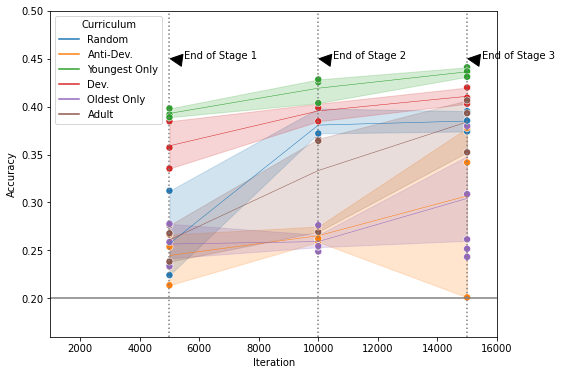

In [18]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5, err_style='band')#'bars')
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.2, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.16,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig1-b_toybox_categorization.pdf', dpi=300)

In [20]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    print('---------------stage:',stage)
    for i, fp in enumerate(tqdm(fpathlist)):
        tag = get_tag(fp)
        curr = tagname_dict[tag]
#         print(fp)
#         print(tag, curr)
        tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

---------------stage: 1


100%|███████████████████████████████████████████| 18/18 [00:21<00:00,  1.19s/it]


---------------stage: 2


100%|███████████████████████████████████████████| 21/21 [00:29<00:00,  1.39s/it]


---------------stage: 3


 86%|████████████████████████████████████▊      | 18/21 [00:29<00:04,  1.56s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
100%|███████████████████████████████████████████| 21/21 [00:35<00:00,  1.70s/it]


In [21]:
df_all = pd.DataFrame.from_records(record_list)

Text(15500, 0.65, 'End of Stage 3')

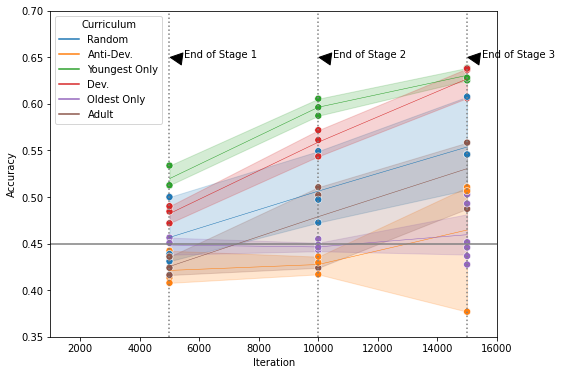

In [22]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5)
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.35,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig1-b_toybox_transformation.pdf', dpi=300)

### 000 vs 012

In [7]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/toybox/may15/'

In [17]:
record_list = []
iter_per_stage = 5000
for stage in range(2,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    print('---------------stage:',stage)
    for i, fp in enumerate(tqdm(fpathlist)):
        tag = get_tag(fp)
        curr = tagname_dict[tag]
#         print(fp)
#         print(tag, curr)
        tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'category')
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

---------------stage: 2


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]


---------------stage: 3


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.87s/it]


In [18]:
df_all = pd.DataFrame.from_records(record_list)

Text(15500, 0.65, 'End of Stage 3')

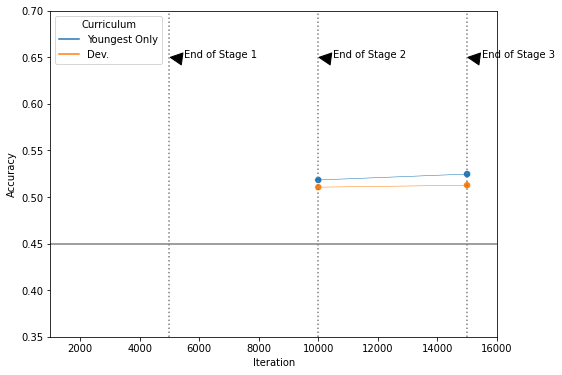

In [19]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5)
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.35,0.7])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig1-b_toybox_transformation.pdf', dpi=300)

In [20]:
record_list = []
iter_per_stage = 5000
for stage in range(2,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    print('---------------stage:',stage)
    for i, fp in enumerate(tqdm(fpathlist)):
        tag = get_tag(fp)
        curr = tagname_dict[tag]
#         print(fp)
#         print(tag, curr)
        tag = tag.replace('g3','ga')
        score = proc_fp(fp, 'transformation')
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

---------------stage: 2


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


---------------stage: 3


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.18it/s]


In [21]:
df_all = pd.DataFrame.from_records(record_list)

In [23]:
df_all

,fname,tag,Curriculum,Iteration,Accuracy
0,embeddings_g0_seed_721__adamw_pre.g0,g0g0,Youngest Only,10000,0.715893
1,embeddings_g1_seed_721__adamw_pre.g0,g0g1,Dev.,10000,0.756681
2,embeddings_g2_seed_721_adamw_pre.g0g1,g0g1g2,Dev.,15000,0.763010
3,embeddings_g0_seed_721_adamw_pre.g0g0,g0g0g0,Youngest Only,15000,0.747539


Text(15500, 0.65, 'End of Stage 3')

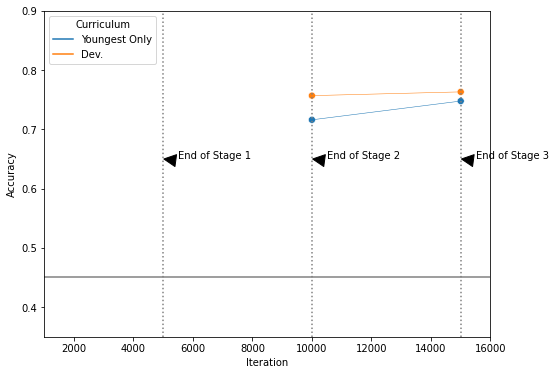

In [25]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5)
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50)
# sns.lineplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, linestyle='--', legend=False)
# sns.scatterplot(data=df_all, x='Iteration', y='Validation Loss', hue='Curriculum', ax=ax, legend=False, s=10)

ax.axhline(y=0.45, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.35,0.9])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.65), xytext=(5500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.65), xytext=(10500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.65), xytext=(15500, 0.65),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig1-b_toybox_transformation.pdf', dpi=300)

## UCF101

In [6]:
def get_separability_score(df, label, method='sgd', ret_preds=False):
    # method: sgd or svm
#     le = preprocessing.LabelEncoder()
    y = df[label] #le.fit_transform(df[label])
    
    X_cols = ['dim'+str(i)
              for i in range(768)]
    X = df[X_cols]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    if method=='svm':
        clf = make_pipeline(StandardScaler(),
                            LinearSVC(random_state=0, tol=1e-4))
    elif method=='sgd':
        clf = make_pipeline(StandardScaler(),
                            SGDClassifier(max_iter=1000, tol=1e-4, n_jobs=40))#, loss='log_loss'))
    else:
        raise ValueError()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    if ret_preds:
        preds = clf.predict(X_test)
        return train_score, test_score, preds, y_test
    return train_score, test_score

In [7]:
def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[2]
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        full_tag = glast
    return full_tag

def proc_fp(fp):
    df = pd.read_csv(fp)
    
    method='sgd'
    train_score, test_score = get_separability_score(df, 'labels', method=method, ret_preds=False)
    return test_score

In [8]:
tagname_dict = {
    'g0':'Dev.', 
    'g0g1': 'Dev.', 
    'g0g1g2': 'Dev.',
    'g2':'Anti-Dev.', 
    'g2g1': 'Anti-Dev.', 
    'g2g1g0': 'Anti-Dev.',
    'gr': 'Random',
    'grgr': 'Random',
    'grgrgr': 'Random',
    'g2g2': 'Oldest Only',
    'g2g2g2': 'Oldest Only',
    'g3': 'Adult',
    'g3g1': 'Adult',
    'g3g1g2': 'Adult',
    'g0g0': 'Youngest Only',
    'g0g0g0': 'Youngest Only'}

In [82]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/may14/'

In [83]:
def get_seed(fp):
    return int(Path(fp).stem.split('_')[4])
get_seed(fp)

563

In [84]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    for i, fp in enumerate(tqdm(fpathlist)):
        if Path(fp).stem.split('_')[1]=='na':
            continue
        tag = get_tag(fp)
        curr = tagname_dict[tag]
        if (curr=='Youngest Only') | (curr=='Oldest Only'):
            continue
        tag = tag.replace('g3','ga')
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

  0%|                                                    | 0/22 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  5%|██                                          | 1/22 [01:10<24:46, 70.78s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  9%|████                                        | 2/22 [02:38<26:56, 80.83s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

 12%|█████▌                                      | 3/24 [02:50<19:47, 56.56s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 25%|███████████                                 | 6/24 [04:14<11:15, 37.52s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 33%|██████████████▋                             | 8/24 [05:20<09:33, 35.85s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

In [70]:
# fp='/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/may14/s1/embeddings_na.csv'
# proc_fp(fp)

In [85]:
df_all = pd.DataFrame.from_records(record_list)

In [86]:
# df_all.to_csv('data_ucf_may17.csv', index=False)

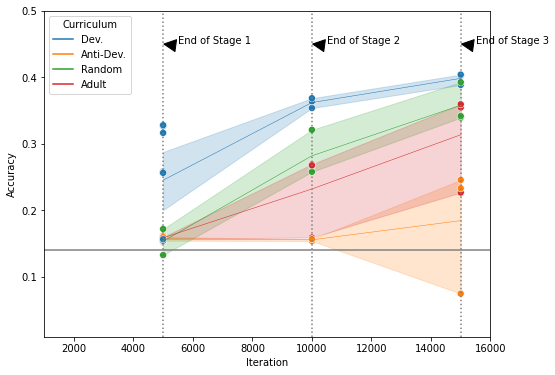

In [88]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5,
            hue_order=hue_order)
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50,
               hue_order=hue_order)

ax.axhline(y=0.14, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.01,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig_ucf.pdf', dpi=300)

### Temp: Youngest and oldest only

In [28]:
def get_seed(fp):
    stem = Path(fp).stem
    parts = stem.split('_')
    return parts[4]

def get_tag(fp):
    # g0g1g2, g2g1g0, g3g1g2, grgrgr, g2g2g2
    # g0, g2, g3, gr
    # g0g1, g2g1, g2g2, grgr, g3g1
    stem = Path(fp).stem
    parts = stem.split('_')
    glast = parts[2]
    
    seed = get_seed(fp)
    try:
        seed = int(seed)
    except:
        warnings.warn('seed cannot be converted to int for'+stem)
    
    if 'pre' in stem:
        gpre = parts[-1]
        gpre = gpre.replace('pre.', '')
        
        full_tag = gpre+glast
    else:
        # stage 1 results
        if seed>500: ##### buggy assumption. relies on the seed for distinguishing between g0 of g0g0g0 and g0 of g0g1g2
            glast = glast+'o'
        full_tag = glast
    return full_tag

tagname_dict = {
    'g0':'Dev.', 
    'g0g1': 'Dev.', 
    'g0g1g2': 'Dev.',
    'g2':'Anti-Dev.', 
    'g2g1': 'Anti-Dev.', 
    'g2g1g0': 'Anti-Dev.',
    'gr': 'Random',
    'grgr': 'Random',
    'grgrgr': 'Random',
    'g2o': 'Oldest Only',
    'g2g2': 'Oldest Only',
    'g2g2g2': 'Oldest Only',
    'g3': 'Adult',
    'g3g1': 'Adult',
    'g3g1g2': 'Adult',
    'g0o':'Youngest Only',
    'g0g0':'Youngest Only',
    'g0g0g0':'Youngest Only'}

def proc_fp(fp):
    df = pd.read_csv(fp)
    
    method='sgd'
    train_score, test_score = get_separability_score(df, 'labels', method=method, ret_preds=False)
    return test_score

In [30]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/may14/'

In [32]:
record_list = []
iter_per_stage = 5000
for stage in range(1,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    print('------- stage', stage)
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(fp)
        tag = get_tag(fp)
        curr = tagname_dict[tag]
        tag = tag.replace('g3','ga')
        if (curr!='Youngest Only') and (curr!='Dev.'):
            continue #@@@
#         print(tag,curr)
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

------- stage 1


  0%|                                                    | 0/21 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  5%|██                                          | 1/21 [00:15<05:07, 15.38s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 14%|██████▎                                     | 3/21 [00:38<03:48, 12.68s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

------- stage 2


  0%|                                                    | 0/24 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
  8%|███▋                                        | 2/24 [00:12<02:14,  6.10s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 29%|████████████▊                               | 7/24 [00:23<00:53,  3.14s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

------- stage 3


  0%|                                                    | 0/24 [00:00<?, ?it/s]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 12%|█████▌                                      | 3/24 [00:11<01:23,  3.96s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 17%|███████▎                                    | 4/24 [00:23<02:10,  6.54s/it]/N/soft/sles15/deeplearning/Python-3.10.5/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to impro

In [33]:
df_all = pd.DataFrame.from_records(record_list)

In [34]:
# df_all.to_csv('data_ucf_temp.csv', index=False)

Text(15500, 0.45, 'End of Stage 3')

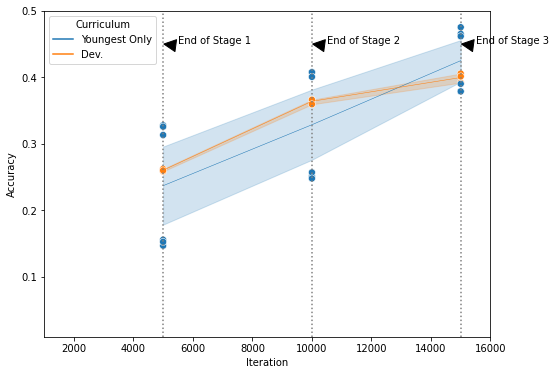

In [35]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5)
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50)

# ax.axhline(y=0.45, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.01,0.5])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig1-b_ucf.pdf', dpi=300)

## 000 vs 012

In [29]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/benchmarks/ucf101/may15/'

In [30]:
record_list = []
iter_per_stage = 5000
for stage in range(2,4):
    emb_dir = emb_root+'s'+str(stage)+'/'
    fpathlist = [emb_dir+fname
                for fname in os.listdir(emb_dir)
                if Path(emb_dir+fname).suffix=='.csv']
    print('------- stage', stage)
    for i, fp in enumerate(tqdm(fpathlist)):
#         print(fp)
        tag = get_tag(fp)
        curr = tagname_dict[tag]
        tag = tag.replace('g3','ga')
        if (curr!='Youngest Only') and (curr!='Dev.'):
            continue #@@@
#         print(tag,curr)
        score = proc_fp(fp)
        record = {'fname': Path(fp).stem,
                  'tag': tag,
                  'Curriculum': curr,
                 'Iteration': iter_per_stage*stage,
                  'Accuracy': score}
        record_list.append(deepcopy(record))

------- stage 2


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.46s/it]


------- stage 3


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.47s/it]


In [31]:
df_all = pd.DataFrame.from_records(record_list)

Text(15500, 0.45, 'End of Stage 3')

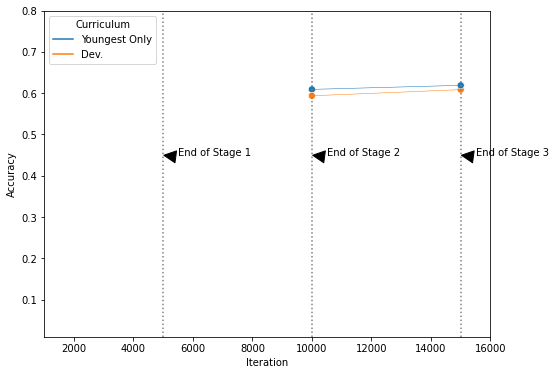

In [34]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, linewidth=0.5)
sns.scatterplot(data=df_all, x='Iteration', y='Accuracy', hue='Curriculum', ax=ax, legend=False, s=50)

# ax.axhline(y=0.45, color='gray', linestyle='solid')


ax.axvline(x=5000, color='gray', linestyle=':')
ax.axvline(x=10000, color='gray', linestyle=':')
ax.axvline(x=15000, color='gray', linestyle=':')

ax.set_xlim([1000.,16000])
ax.set_ylim([0.01,0.8])
# Add annotations to the vertical lines
# ax.set_xlim([-500,15000])
# ax.annotate('Stage 1', xy=(1000, 1), xytext=(1500, 1),
#             arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 1', xy=(5000, 0.45), xytext=(5500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 2', xy=(10000, 0.45), xytext=(10500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('End of Stage 3', xy=(15000, 0.45), xytext=(15500, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05))

# ax.annotate('Untrained Network', xy=(1500, 0.2), xytext=(1500, 0.215),
#             arrowprops=dict(facecolor='black', shrink=0.05))

# for i in range(df_all.shape[0]):
#     plt.text(data['x'][i] + 0.1, data['y'][i] + 0.1, data['label'][i])


# plt.savefig('fig1-b_ucf.pdf', dpi=300)